# Introduction

In this Notebook we will try different models by creating train and test dataframe .We will train our models and check the accuracy.After that we will compare all the models and find out which one has performed the best ..!!

First we will need to select best features for our model and after that we will train them according to that..!!

Here we will try 



XGBOOST Classifier , 
Random Forest , 
Logistic Regression ,
Light GBM


# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# Changing current working directory

In [2]:
import os
cwd = os.getcwd()
print (cwd)
%cd "Instacart data"

C:\Users\dhari\BDIA_Spring19\BDIA_FINAL_PROJECT
C:\Users\dhari\BDIA_Spring19\BDIA_FINAL_PROJECT\Instacart data


# Read Inputs into data frame

In [4]:
order_products_train = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__train.csv")
order_products_prior = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__prior.csv")
orders = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/orders.csv")
products = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/products.csv")
aisles = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/aisles.csv")
departments = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/departments.csv")

Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [5]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


Now, let's concatenate them in the same order_products dataframe. This will concatenate all orders from previous customers plus new customers

In [6]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


# Missing Data in all orders

In [7]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

Total Missing  Percent
reordered                      0      0.0
add_to_cart_order              0      0.0
product_id                     0      0.0
order_id                       0      0.0

There is no missing data in order_products_all dataset

# Reorder Frequency

In [8]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

C:\Users\dhari\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


reordered  Total_products    Ratios
0          0        13863746  0.409938
1          1        19955360  0.590062

59 % of ordered products are previously ordered by customers.

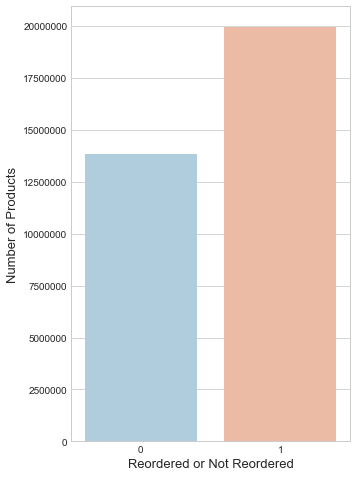

In [9]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# To predict which previously purchased products will be in a user’s next order

Step 1 We will start with reading the orders file.

In [10]:

orders_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/orders.csv", usecols=["order_id","user_id","order_number"])

Since the objective is to predict which previously purchased products will be in next order, let us first get the list of all products purchased by the customer.

Step 2 Create data frame with old purchase

In [11]:
# read the prior order file #
prior_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__prior.csv")

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

order_id  product_id  add_to_cart_order  reordered  user_id  order_number
0         2       33120                  1          1   202279             3
1         2       28985                  2          1   202279             3
2         2        9327                  3          0   202279             3
3         2       45918                  4          1   202279             3
4         2       30035                  5          0   202279             3

Step 3 Create data frame with latest purchase

In [12]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

user_id  product_id  reordered_latest
0    59897        9755                 1
1    59897       31487                 0
2    59897       37510                 1
3    59897       14576                 1
4    59897       22105                 0

Step 4. Get count of Number of reorders

In [13]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

user_id  product_id  reordered_count  reordered_sum
0        1         196               10              9
1        1       10258                9              8
2        1       10326                1              0
3        1       12427               10              9
4        1       13032                3              2

Step 5 merge the prior df with latest df

In [14]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

user_id  product_id  reordered_count  reordered_sum  reordered_latest
0        1         196               10              9               1.0
1        1       10258                9              8               1.0
2        1       10326                1              0               NaN
3        1       12427               10              9               1.0
4        1       13032                3              2               1.0

Read the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.

In [15]:
orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__train.csv", usecols=["order_id"])
train_df.head()

order_id
0         1
1         1
2         1
3         1
4         1

Step 6 Get distinct order id in train_df. This will help in joining the data frame with orders

In [16]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

order_id
0         1
1        36
2        38
3        96
4        98

join with Orders data frame

In [17]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

order_id  user_id
0         1   112108
1        36    79431
2        38    42756
3        96    17227
4        98    56463

In [19]:
test_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/sample_submission.csv", usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

order_id  user_id
0        17    36855
1        34    35220
2       137   187107
3       182   115892
4       257    35581

Step 7 : Prepare test data frames

In [20]:
print(train_df.shape, test_df.shape)

(131209, 2) (75000, 2)


Step 8: Merge the train and test data with prior_df to get the products purchased previously by the customer.

In [21]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

order_id  user_id  product_id  reordered_count  reordered_sum  \
0         1   112108        2067                1              0   
1         1   112108        5707                2              1   
2         1   112108       11109                2              1   
3         1   112108       14947                3              2   
4         1   112108       22035                2              1   

   reordered_latest  
0               NaN  
1               1.0  
2               NaN  
3               1.0  
4               NaN

In [22]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()

order_id  user_id  product_id  reordered_count  reordered_sum  \
0        17    36855        1283                1              0   
1        17    36855        6291                1              0   
2        17    36855        7035                1              0   
3        17    36855       11494                1              0   
4        17    36855       13107                3              2   

   reordered_latest  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               1.0

In [25]:
products_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

product_id  aisle_id  department_id
0           1        61             19
1           2       104             13
2           3        94              7
3           4        38              1
4           5         5             13

Step 9 : Add more features to training data from Products data frame

In [26]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

order_id  user_id  product_id  reordered_count  reordered_sum  \
0         1   112108        2067                1              0   
1        96    17227        2067                1              0   
2      3243   206024        2067                1              0   
3     12950    11456        2067                1              0   
4     17683   177724        2067                1              0   

   reordered_latest  aisle_id  department_id  
0               NaN         3             19  
1               NaN         3             19  
2               NaN         3             19  
3               0.0         3             19  
4               NaN         3             19

In [27]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

order_id  user_id  product_id  reordered_count  reordered_sum  \
0        17    36855        1283                1              0   
1    657743    16994        1283                1              0   
2    834223    92628        1283                1              0   
3   1446886    75870        1283                1              0   
4   1518981   118458        1283                3              2   

   reordered_latest  aisle_id  department_id  
0               NaN       100             21  
1               NaN       100             21  
2               NaN       100             21  
3               NaN       100             21  
4               NaN       100             21

Now we have all the products that has been purchased previously by the customer along with some characteristics / featrures. So we can use the train dataset to populate the target variable i.e., whether the product has been reordered in the next order.

In [29]:
train_y_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


# XGBOOST CLASSIFIER

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.

XGBoost provides a wrapper class to allow models to be treated like classifiers or regressors in the scikit-learn framework.

This means we can use the full scikit-learn library with XGBoost models.

The XGBoost model for classification is called XGBClassifier.

In [30]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [31]:
X=train_df.drop('reordered',axis=1)

In [32]:
X.head()

order_id  user_id  product_id  reordered_count  reordered_sum  \
0         1   112108        2067                1              0   
1        96    17227        2067                1              0   
2      3243   206024        2067                1              0   
3     12950    11456        2067                1              0   
4     17683   177724        2067                1              0   

   reordered_latest  aisle_id  department_id  
0               NaN         3             19  
1               NaN         3             19  
2               NaN         3             19  
3               0.0         3             19  
4               NaN         3             19

In [33]:
Y =train_df['reordered']

In [34]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: reordered, dtype: float64

Step 10: split data into train and test sets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [36]:
model = XGBClassifier()

Step 11: Train the model using XGBClassifier

In [37]:
model.fit(X_train, y_train)

[23:56:32] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [38]:
y_pred = model.predict(X_test)

C:\Users\dhari\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
predictions = [round(value) for value in y_pred]

In [40]:
accuracy = accuracy_score(y_test, predictions)

### Accuracy for the  XGBoost Classifier

In [42]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.43%


In [43]:
# target variable for train set #
train_y = train_df.reordered.values

# dataframe for test set predictions #
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns #
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

(8474661, 6) (4833292, 6)


Step 12: Create XGb function

In [44]:
#create XGb function to run the model and you can pass train and test 

def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

Step 13: Run the XGB function on training np array

In [45]:
# run the xgboost model #
pred = runXGB(train_df, train_y, test_df)
#del train_df, test_df

# use a cut-off value to get the predictions #
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.ix[out_df["Pred"].astype('int')==1]

[00:12:45] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


C:\Users\dhari\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [46]:
# when there are more than 1 product, merge them to a single string #
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]

Step 14: Load result in the output file

In [47]:
# read the sample csv file and populate the products from predictions #
sub_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# when there are no predictions use "None" #
sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv("../BDIA_FINAL_PROJECT/Instacart data/xgb_starter_3450.csv", index=False)

In [48]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

order_id  user_id  product_id  reordered_count  reordered_sum  \
3052321   2634088    11335        6873                1              0   
5273294   3379345   104957       15923                1              0   
6564246   1344587   174152       45692                1              0   
7705447   2206969   196469       31205                1              0   
6947171   1103780    57331       28599                1              0   
3706974   2174683   125292       12845                1              0   
8344595   1026666    56033       45362                2              1   
5605328   2860146    80015       43460                8              7   
5248902     15763    71816       19863                5              4   
462416     232693    77967       41220                1              0   
3534830   1949599   126310       22455                4              3   
152552    2345085    14486       16759                2              1   
7075812    546353    10292        5640                4              3   
8350743   1529794    45915       33669                2              1   
932819    1326500   151546        8021                6              5   
634424     975625    96703        2124                5              4   
4886941    605046   128734       21783                5              4   
853923    2935574    80460       42265                1              0   
419655    2998179   194826       35939                3              2   
7392080   1346708    65077       37890                2              1   
120382     191662   176974        9339                2              1   
8376309   1501971    50250       10920                3              2   
3979156   1667567    49263        7632                1              0   
5171212   2816793   192902        5120                5              4   
7198817    724567     8537       39415                2              1   
3374561   2242001    91387       13212                1              0   
3166358   3237266   139704       32433                1              0   
2006024   3318883   162705       42736                1              0   
2162102   2933314   165923       13198                1              0   
2056046    685749   150118       10957                1              0   
...           ...      ...         ...              ...            ...   
163256    1975041   101364       19048                1              0   
4448386   1185135    11392       35018                1              0   
8314439   1323235   103227       18311                1              0   
6064686   1926655    17049        4289                1              0   
8276278   2783277    37625       32091                1              0   
1867829    446443    96660       14678                1              0   
1210708   1278001    39418       35042                1              0   
6339780   2317913   182465        8223                1              0   
1703958    486212    54577       37710                2              1   
2897807    753264    63056       22882                1              0   
407478    2791029   143348       34126                3              2   
4176911   2444859    41833       48871                3              2   
3111695   1322715   186249       23165                1              0   
3305494   1620270    23331       10644                1              0   
7593250   2861237   154062       35865                4              3   
3114083   2663723    86688       23165                1              0   
1880042   3416466    54088       21267                1              0   
8184488   1349969    50097         961                1              0   
7550567   2335041   154775       10131                1              0   
3160939   3174825   122942       31066                1              0   
3747474   1598025   123149        6348                3              2   
5865723   2756562   174406       19204                2              1   
1442064    63

# Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.
<img src="linear_vs_logistic_regression.jpg">

In [1]:
#Import Library
from sklearn.linear_model import LogisticRegression

In [50]:
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

In [51]:
#fitting the model
clf.fit(X_train, y_train)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
#predictions
pred=clf.predict(X_test)

In [53]:
#accuracy score of Logistic Regression Model
print(accuracy_score(pred, y_test))

0.9019834165224757


Logistic Regrassion is 90% accurate on predicting if people will reorder or not based on test data

# Random Forest 

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [54]:
#Import Library
from sklearn.ensemble import RandomForestClassifier

C:\Users\dhari\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [55]:
#Define Features
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

In [56]:
#Fitting the model
clfrf.fit(X_train, y_train)

C:\Users\dhari\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\dhari\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1000,
            min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [57]:
#predictions
predrf=clfrf.predict(X_test)

In [58]:
#accuracy score for the random forest model
accuracy_score(predrf, y_test)

0.904515384359583

Random Forest is 90% accurate on predicting if people will reorder or not based on test data

# Light GBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency.
Lower memory usage.
Better accuracy.
Support of parallel and GPU learning.
Capable of handling large-scale data.

<img src="lightgbm.jpg">

In [60]:
#install the lightgbm using pip
!pip install lightgbm

In [61]:
#import Library
import lightgbm as lgb

In [62]:
#split into train and test
train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

In [63]:
#define model
model= lgb.LGBMClassifier()

In [64]:
#fitting the model
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [65]:
#prediction
pred=model.predict(X_test)

C:\Users\dhari\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [66]:
#accuracy score of Light GBM
print(accuracy_score(pred, y_test))

0.9047006066925334


Light GBM is 90% accurate on predicting if people will reorder or not based on test data

# Conclusion

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.

XGBoost provides a wrapper class to allow models to be treated like classifiers or regressors in the scikit-learn framework.

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

Faster training speed and higher efficiency

After Trying Different Models We have found out XGBoost is the best model that outperform othe models..!!

We are getting following results on applying data set on different models:

| Model | R2 Score |
| --- | --- |
| Logistic Regression | 0.831 |
| Random Forest Regression  | 0.804 |
| XG Boost | 0.904 |
| LGBM | 0.904 |

# References



[1] Cui, G., Wong, M. L., & Lui, H. K. (2006). Machine learning for direct marketing response models:
Bayesian networks with evolutionary programming.Management Science, 52(4), 597-612

[2] https://www.kaggle.com/omarito/word2vec-for-products-analysis-0-01-lb

[3] https://en.wikipedia.org/wiki/Xgboost

[4] https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vsxgboost/

* The text in the document by Source Wikipedia is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

* The text in the document by Analytics Vidhya is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

* The text in the document by towards data science is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

* The code in the document by Source Kaggle is licensed under the MIT License https://opensource.org/licenses/MIT

# Licence

Copyright 2019 DHARIT SHAH

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.